In [1]:
import json
import re
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
import matplotlib.pyplot as plt


os.chdir("..")
import utils

### Step 1: load cases

In [2]:
QUERY = "fence built on my property"

In [3]:
file_name = "data/output_{}.json".format(QUERY.replace(" ", "-"))

if os.path.exists(file_name):
    # load data
    with open(file_name, 'r') as f:
        cases = json.load(f)
else:
    # query data
    response = utils.get_request_caselaw("https://api.case.law/v1/cases/?search='{}'&full_case=TRUE".format(QUERY)).json()
    cases = response['results']
    
    i = 1 # limit to 5 requests (500 cases) because that should be more than enough
    while response['next'] and i < 5: 
        response = utils.get_request_caselaw(response['next']).json()
        cases.extend(response['results'])
        i += 1
    
    with open(file_name, 'w') as f:
        json.dump(cases, f)

Structure of `response` dict:
```
{  
    "count"    : total number of matching cases  
    "next"     : url to query for next 100 cases  
    "previous" : url to query for previous 100 cases  
    "results"  : [ (max length 100)
        {
            "name"          : **case name**
            "decision_date" : case date
            "citations"     : [
                {
                    "cite" : name of law
                    "type" : ??
                },
                ...
            ]
            "frontend_url"  : clean look at case
            "casebody"      : { (if full_case=FALSE, this field is not present)
                "status" : should equal ok
                "data"   : {
                    "opinions"    : [ (for non-supreme court cases, just one opinion)
                        {
                            "author" : name of judge
                            "type"   : indicates type of opinion (majority/dissent/etc)
                            "text"   : opinion text
                        },
                        ...
                    ]
                    "head_matter" : **case description text**
            }
        },
        ...
    ]
}
```

### Step 2: pre-processing

In [4]:
for case in cases:
    # get rid of non-ok cases
    if case['casebody']['status'] != 'ok':
        cases.remove(case)
        continue

In [5]:
# enforce case ordering
case_names = [case['name'] for case in cases]

case_texts = [case['casebody']['data']['head_matter'].replace("\n", " ") for case in cases]
    
case_opinions = []
for opinions in [case['casebody']['data']['opinions'] for case in cases]:
    for opinion in opinions:
        if opinion['type'] == "majority":
            case_opinions.append(opinion['text'].replace("\n", " "))
            break

### Step 3: rank cases

In [6]:
# # define tokenizer that handles stemmings
# # sourced from https://gist.github.com/deargle/b57738c8ce2b4ed6ca90f86d5422431f
# trans_table = {ord(c): None for c in string.punctuation + string.digits}    
# stemmer = PorterStemmer()

# def tokenize(text):
#     return [stemmer.stem(word) for word in word_tokenize(text.translate(trans_table)) if len(word) > 1]
    
# # compute tf-idf scores
# vec = TfidfVectorizer(tokenizer=tokenize, 
#                       min_df=.05, 
#                       max_df=0.8, 
#                       max_features=5000, 
#                       stop_words=[stemmer.stem(item) for item in ENGLISH_STOP_WORDS], 
#                       norm='l2')

# compute tf-idf scores
vec = TfidfVectorizer(min_df=.05, 
                      max_df=0.8, 
                      max_features=5000, 
                      stop_words='english', 
                      norm='l2')

tfidf_matrix = vec.fit_transform(case_texts + [QUERY]).toarray()
tokens = vec.get_feature_names()

print("(stemmed) tokens considered by vectorizer:")
print(tokens)

(stemmed) tokens considered by vectorizer:
['000', '10', '100', '11', '12', '13', '14', '15', '150', '16', '17', '18', '1889', '19', '1907', '1st', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2d', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3d', '40', '41', '42', '43', '44', '45', '46', '50', '52', '54', '55', '57', '59', '60', '61', '63', '64', '66', '70', '78', '80', '81', '88', '91', '99', 'absence', 'accepted', 'accordance', 'according', 'account', 'acquiescence', 'acquired', 'acre', 'acres', 'act', 'acting', 'action', 'acts', 'actual', 'actually', 'addition', 'adjacent', 'adjoining', 'admissible', 'admission', 'admitted', 'adverse', 'affect', 'affirmed', 'aforesaid', 'agent', 'agree', 'agreed', 'agreement', 'al', 'alleged', 'alleges', 'allen', 'allow', 'allowed', 'animals', 'answer', 'app', 'appeal', 'appealed', 'appeals', 'appear', 'appeared', 'appears', 'appellant', 'appellants', 'appellate', 'appellee', 'appellees', 'application', 'applied', 'a

In [30]:
# compute cosine similarity of cases to search query
query_vec = tfidf_matrix[-1]
scores = [cosine_similarity(query_vec.reshape(1,-1), doc_vec.reshape(1,-1))[0][0] for doc_vec in tfidf_matrix[:-1]]

In [31]:
# display results
cosine_similarities = [(k,v, case_names.index(k)) for k,v in zip(case_names, scores)]
results = pd.DataFrame(cosine_similarities, columns=['case_name', 'score', 'original_rank']).sort_values('score', ascending=False).reset_index(drop=True)
results.head(20)

,case_name,score,original_rank
0,Thayer vs. Wright,0.306225,5
1,ROWLAND v. BAIRD,0.305989,0
2,Smith versus Johnson,0.295209,6
3,"Philip Saperstein, Plaintiff, v. Daniel Berman...",0.282951,2
4,GOODALE v. SOWELL,0.257046,14
5,Jim Langston et al. v. G. H. Maxey,0.248051,3
6,"Gulf, Colorado & Santa Fe Railway Co. v. E. B....",0.247283,21
7,Benjamin Wright against Martin Wright,0.247059,34
8,Krum & Peters versus Anthony,0.235049,211
9,Davis vs. Townsend,0.233323,110


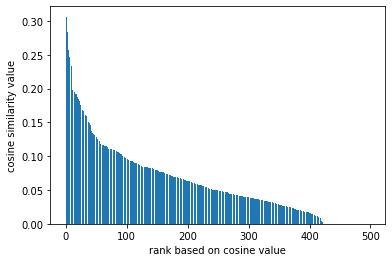

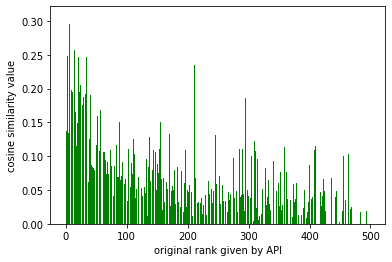

In [9]:
plt.bar(results.index, results.score)
plt.xlabel('rank based on cosine value')
plt.ylabel('cosine similarity value')
plt.show()
plt.bar(results.original_rank, results.score, color='green')
plt.xlabel('original rank given by API')
plt.ylabel('cosine similarity value')
plt.show()

### Step 4: determine outcome of case

In [10]:
opinion_counts = {}
for idx, case in enumerate(cases):
    try:
        opinion_counts[len(case['casebody']['data']['opinions'])] += 1
    except KeyError:
        opinion_counts[len(case['casebody']['data']['opinions'])] = 1

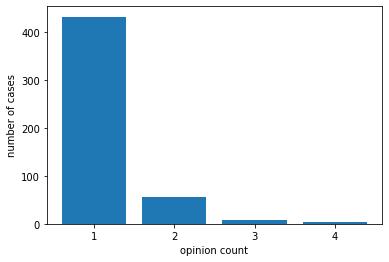

In [11]:
plt.bar(opinion_counts.keys(), opinion_counts.values())
plt.xticks(range(1,len(opinion_counts)+1))
plt.xlabel('opinion count')
plt.ylabel('number of cases')
plt.show()